[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sjut/HSE-Compling/blob/master/seminars/7_Sentiment.ipynb)

In [1]:
!pip install innvestigate

     |████████████████████████████████| 102kB 4.1MB/s 
     |████████████████████████████████| 317kB 18.4MB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [2]:
!pip install tensorflow==1.14.0  # я не знаю, починили ли за это время tensorflow, но вторая его версия не работает на винде

     |████████████████████████████████| 109.2MB 29kB/s 
     |████████████████████████████████| 491kB 61.6MB/s 
     |████████████████████████████████| 3.2MB 55.3MB/s 
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0


In [3]:
import re
import keras.backend
import keras.models
import matplotlib.pyplot as plt
from matplotlib import cm, transforms

import numpy as np
import pandas as pd
import os
import pickle
import time

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [4]:
!wget http://vectors.nlpl.eu/repository/11/180.zip
!unzip 180.zip

--2020-11-18 09:29:37--  http://vectors.nlpl.eu/repository/11/180.zip
Resolving vectors.nlpl.eu (vectors.nlpl.eu)... 129.240.189.225
Connecting to vectors.nlpl.eu (vectors.nlpl.eu)|129.240.189.225|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 484452285 (462M) [application/zip]
Saving to: ‘180.zip’

180.zip             100%[===================>] 462.01M  7.73MB/s    in 97s     

2020-11-18 09:31:16 (4.76 MB/s) - ‘180.zip’ saved [484452285/484452285]

Archive:  180.zip
  inflating: README                  
  inflating: meta.json               
  inflating: model.bin               
  inflating: model.txt               


In [5]:
!wget https://raw.githubusercontent.com/sjut/HSE-Compling/master/seminars/data/reviews_tok.txt
!wget https://raw.githubusercontent.com/sjut/HSE-Compling/master/seminars/data/reviews_scores.txt

--2020-11-18 09:31:24--  https://raw.githubusercontent.com/sjut/HSE-Compling/master/seminars/data/reviews_tok.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8489426 (8.1M) [text/plain]
Saving to: ‘reviews_tok.txt’

reviews_tok.txt     100%[===================>]   8.10M  29.7MB/s    in 0.3s    

2020-11-18 09:31:25 (29.7 MB/s) - ‘reviews_tok.txt’ saved [8489426/8489426]

--2020-11-18 09:31:25--  https://raw.githubusercontent.com/sjut/HSE-Compling/master/seminars/data/reviews_scores.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 373

## Данные
Будем использовать кусочек данных с соревнования SentiRuEval.
Они уже предобработаны (лемматизированы и размечены POS-тегами). Каждый текст - строчка из токенов *лемма_тег*.
Оценки усреднены по трем аспектам, шкалированы от 1 до 10.
Мы будем строить бинарную классификацию, поэтому будем считать оценки выше 5 положительными, а 5 и ниже — отрицательными.

In [6]:
texts = []
with open("reviews_tok.txt") as f:
    for line in f:
        texts.append(line.rstrip('\r\n').split())
scores = []
with open("reviews_scores.txt") as f:
    scores = list(map(lambda x: float(x.rstrip("\r\n")), f.readlines()))

In [7]:
scores = np.array(scores)
binary_scores = scores > 5.
print(binary_scores[0])

True


In [8]:
binary_scores

array([ True,  True,  True, ..., False,  True,  True])

In [9]:
binary_scores = binary_scores.astype(int)

In [10]:
def max_length(texts):
    return max(len(t) for t in texts)

In [11]:
print(len(texts))
print(len(scores))

2994
2994


Какие вообще есть способы расценить текст как положительный или как отрицательный?

## Задание


Словарь......
Словарь можно делать руками, но таким мракобесием мы точно сейчас не будем заниматься)


Давайте найдём тут биграммы.

Посчитаем $tf*idf$ для токенов и биграмм сначала на всем корпусе, а затем отдельно для положительных и отрицательных отзывов.

Потом попробуем тупр посчитать частотность

In [24]:
import gensim

import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [38]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(texts, min_count=5, threshold=50) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[texts], threshold=50)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [39]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [40]:
textb = make_bigrams(texts)

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=5)

In [42]:
tfidf_matrix = vectorizer.fit_transform(" ".join(t) for t in textb)

In [43]:
tfidf_matrix.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [44]:
text1_tfidf = vectorizer.transform([" ".join(textb[0])])

In [45]:
vocab = vectorizer.get_feature_names()
tfidf = vectorizer.idf_
top = list(sorted(zip(vocab, text1_tfidf.toarray()[0]), key=lambda x: x[1])) [:30]

In [46]:
top

[('000_num', 0.0),
 ('00_num', 0.0),
 ('01', 0.0),
 ('01_num', 0.0),
 ('02', 0.0),
 ('03', 0.0),
 ('04', 0.0),
 ('04_num', 0.0),
 ('05', 0.0),
 ('05_num', 0.0),
 ('06', 0.0),
 ('06_num', 0.0),
 ('07', 0.0),
 ('07_num', 0.0),
 ('08', 0.0),
 ('08_num', 0.0),
 ('09', 0.0),
 ('09_num', 0.0),
 ('0_num', 0.0),
 ('10', 0.0),
 ('1000_num', 0.0),
 ('1000_num_рубль_noun', 0.0),
 ('100_num', 0.0),
 ('100_num_', 0.0),
 ('10_num', 0.0),
 ('10_num_', 0.0),
 ('10_num_10_num', 0.0),
 ('10_num_балл_noun', 0.0),
 ('11', 0.0),
 ('110_num', 0.0)]

In [51]:

top = list(sorted(zip(vocab, text1_tfidf.toarray()[0]), key=lambda x: x[1], reverse = True))
top [:30]

[('демократичный_adj', 0.42536069696998574),
 ('мять_verb', 0.41727725943015287),
 ('ценник_noun', 0.39809908212124173),
 ('супер_noun', 0.339823937146083),
 ('_punct', 0.3340003272947252),
 ('вполне_adv', 0.3007984129675984),
 ('вкусно_adv', 0.2884638645578946),
 ('понравиться_verb', 0.18642225276178406),
 ('и_part', 0.15588890920721257),
 ('но_cconj', 0.12775395342924187),
 ('не_part', 0.10179289171916675),
 ('000_num', 0.0),
 ('00_num', 0.0),
 ('01', 0.0),
 ('01_num', 0.0),
 ('02', 0.0),
 ('03', 0.0),
 ('04', 0.0),
 ('04_num', 0.0),
 ('05', 0.0),
 ('05_num', 0.0),
 ('06', 0.0),
 ('06_num', 0.0),
 ('07', 0.0),
 ('07_num', 0.0),
 ('08', 0.0),
 ('08_num', 0.0),
 ('09', 0.0),
 ('09_num', 0.0),
 ('0_num', 0.0)]

In [52]:
from collections import Counter
pos_texts = [t for i, t in enumerate(texts) if binary_scores[i]]
word_counter = Counter()
m = vectorizer.transform([' '.join(t) for t in pos_texts])
m = m.toarray()
for j,t in enumerate(pos_texts):
  #top = list(sorted(zip(vocab, m.toarray()[j]), key=lambda x: x[1], reverse = True))
  top = list(sorted(zip(vocab, m[j]), key=lambda x: x[1], reverse = True))
  for w, score in top[:5]:
    word_counter[w] +=1 

In [53]:
word_counter.most_common(100)

[('_punct', 2305),
 ('и_cconj', 313),
 ('не_part', 236),
 ('в_adp', 224),
 ('мы_pron', 155),
 ('я_pron', 133),
 ('с_adp', 94),
 ('_noun', 68),
 ('на_adp', 58),
 ('быть_aux', 49),
 ('свадьба_noun', 37),
 ('вы_pron', 36),
 ('пиво_noun', 34),
 ('очень_adv', 32),
 ('кафе_noun', 27),
 ('пицца_noun', 26),
 ('10_num', 23),
 ('рубль_noun', 23),
 ('_sym', 23),
 ('рождение_noun', 23),
 ('ресторан_noun', 22),
 ('кофе_noun', 22),
 ('_propn', 21),
 ('спасибо_noun', 21),
 ('они_pron', 21),
 ('что_sconj', 20),
 ('000_num', 20),
 ('там_adv', 19),
 ('гость_noun', 18),
 ('ты_pron', 17),
 ('сожаление_noun', 17),
 ('минута_noun', 17),
 ('день_propn', 17),
 ('банкет_noun', 17),
 ('наш_det', 17),
 ('он_pron', 17),
 ('раз_noun', 16),
 ('коктейль_noun', 16),
 ('пальчик_noun', 16),
 ('бар_noun', 16),
 ('этаж_noun', 16),
 ('шашлык_noun', 15),
 ('замечательный_adj', 15),
 ('салат_noun', 15),
 ('праздник_noun', 15),
 ('ни_cconj', 15),
 ('супер_noun', 14),
 ('ребенок_noun', 14),
 ('отличный_adj', 14),
 ('зал_noun'

как удалить стоп слова?

Теперь пойдём не через словарь, а через машинку

## Random Forest
Возьмем представление в виде $tf*idf$ и попробуем обучить на нем классификатор.
Будем использовать Randomm Forest, чтобы легко вытащить важность признаков.

In [54]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
X_train = vectorizer.fit_transform([" ".join(t) for t in texts[:2000]]).toarray()
y_train = binary_scores[:2000]
clf.fit(X_train, y_train)
y_test = binary_scores[2000:]
X_test = vectorizer.transform([" ".join(t) for t in texts[2000:]]).toarray()
clf.score(X_test, y_test)

0.7917505030181087

In [55]:
# А вот так можно посмотреть на самые важные признаки
sorted(zip(vectorizer.get_feature_names(), clf.feature_importances_), key=lambda x: x[1], reverse=True)

[('_punct', 0.006175761690143739),
 ('жалеть_verb', 0.0044679567193859696),
 ('не_part', 0.003671143491541992),
 ('суша_noun', 0.0033629129455501204),
 ('и_cconj', 0.0032840832595423058),
 ('все_pron', 0.00326550427460657),
 ('ехать_verb', 0.003196112620054083),
 ('кухень_noun', 0.0031473256133239453),
 ('очень_adv', 0.0031444283299316804),
 ('в_adp', 0.0031372247817791094),
 ('быть_aux', 0.0031350400433298024),
 ('оценка_noun', 0.003098661937176135),
 ('выбор_noun', 0.0027208973757803967),
 ('за_adp', 0.002717712000305483),
 ('жить_verb', 0.0026958372169115304),
 ('место_noun', 0.0026269662944257426),
 ('этот_det', 0.002625737274016828),
 ('белый_adj', 0.002615095699907937),
 ('на_adp', 0.002531238020570332),
 ('точно_adv', 0.002454958090987014),
 ('из_adp', 0.002445881780919725),
 ('вообще_adv', 0.0024446483402424963),
 ('советовать_verb', 0.0024104450259186875),
 ('по_adp', 0.0023976203416454945),
 ('я_pron', 0.0023072056326211626),
 ('ресторан_noun', 0.0022909092141654075),
 ('масс

**Выводы**: не очень утешительные

## Оценка тональности с помощью CNN

В качестве входных представлений будем использовать word2vec для лемм с POS-тегами UD.
Архитектура классификатора примерно воспроизводит описанную в [статье Arras et al. 2017](http://www.aclweb.org/anthology/W16-1601); а для визуализации воспользуемся библиотекой [iNNvestigate](https://github.com/albermax/innvestigate).

""In this paper, we apply the same LRP technique to a NLP task, where
a neural network maps a sequence of word2vec
vectors representing a text document to its category, and evaluate whether similar benefits in
terms of explanation quality are observed.""

In [56]:
from gensim.models import KeyedVectors
w2v_model = KeyedVectors.load_word2vec_format('model.bin', binary=True)

In [58]:
from sklearn.model_selection import train_test_split
scores_train, scores_val, texts_train, texts_val = train_test_split(
    binary_scores, texts, test_size=0.3)

In [59]:
from collections import Counter
from itertools import chain

MAX_LEN = max(max_length(texts_train), max_length(texts_val))

def load_dataset(lines, embedding_dim, num_examples=None):
    prep = lines[:num_examples]
    vocab = Counter()
    x_tensor = np.zeros((len(prep), MAX_LEN, embedding_dim))
    for i, text in enumerate(prep):
        for j, w in enumerate(text):
            try:
                x_tensor[i, j, :] = w2v_model[w]
            except KeyError:
                pass
        vocab[w] += 1
    return x_tensor, vocab

In [60]:
input_tensor_train, inp_vocab_train = load_dataset(texts_train, w2v_model.vector_size)
input_tensor_val, inp_vocab_val = load_dataset(texts_val, w2v_model.vector_size)

In [61]:
w2v_model.vector_size

300

In [62]:
input_tensor_train.shape

(2095, 1791, 300)

In [63]:
scores_train

array([1, 1, 1, ..., 1, 1, 1])

In [64]:
embedding_dim = w2v_model.vector_size
inp_vocab = inp_vocab_train + inp_vocab_val
vocab_inp_size = len(inp_vocab) + 1

Картинка про плассификатор и оценку значимости входных слов ([источник](https://doi.org/10.1371/journal.pone.0181142.g001)):
<img src="https://camo.githubusercontent.com/ba37f37fdbb90ccd76f1c4bf399e0cb8ddbc66f0/68747470733a2f2f692e696d6775722e636f6d2f595144665335502e706e67"/>

In [65]:
from innvestigate.utils.tests.networks import base as network_base
def build_network(max_len, voc_size, embedding_dim, output_n, activation=None, dense_unit=256, dropout_rate=0.25):
    if activation:
        activation = "relu"

    net = {}
    net["in"] = keras.Input(shape=[1, max_len, embedding_dim])
    net["conv"] = keras.layers.Conv2D(filters=100, kernel_size=(1,2), strides=(1, 1), padding='valid')(net["in"])
    net["pool"] = keras.layers.MaxPooling2D(pool_size=(1, max_len - 1), strides=(1,1))(net["conv"])
    net["out"] = network_base.dense_layer(keras.layers.Flatten()(net["pool"]), units=output_n, activation=activation)
    net["sm_out"] = network_base.softmax(net["out"])


    net.update({
        "input_shape": [1, max_len, embedding_dim],
        "output_n": output_n,
    })
    return net

In [66]:
net = build_network(MAX_LEN, vocab_inp_size, embedding_dim, 2)
model_without_softmax = keras.models.Model(inputs=net['in'], outputs=net['out'])
model_with_softmax = keras.models.Model(inputs=net['in'], outputs=net['sm_out'])

In [67]:
model_without_softmax.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 1791, 300)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 1790, 100)      60100     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 100)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 60,302
Trainable params: 60,302
Non-trainable params: 0
_________________________________________________________________


In [68]:
def to_one_hot(y):
    return keras.utils.to_categorical(y, 2)

def train_model(model, epochs=20):
    
    x_train = np.expand_dims(input_tensor_train, axis=1)
    y_train = to_one_hot(scores_train)
    
    x_val = np.expand_dims(input_tensor_val, axis=1)
    y_val = to_one_hot(scores_val)

    model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])

    history = model.fit(x_train, y_train,
                        batch_size=256,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_val, y_val),
                        shuffle=True)

In [69]:
train_model(model_with_softmax, epochs=10)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 2095 samples, validate on 899 samples
Epoch 1/10
2095/2095 [==============================] - 17s 8ms/step - loss: 0.7553 - acc: 0.7045 - val_loss: 0.7355 - val_acc: 0.7553
Epoch 2/10
2095/2095 [==============================] - 16s 8ms/step - loss: 0.4826 - acc: 0.7986 - val_loss: 0.6973 - val_acc: 0.7386
Epoch 3/10
2095/2095 [==============================] - 15s 7ms/step - loss: 0.3552 - acc: 0.8511 - val_loss: 0.6788 - val_acc: 0.7297
Epoch 4/10
2095/2095 [==============================] - 15s 7ms/step - loss: 0.2767 - acc: 0.8926 - val_loss: 0.6862 - val_acc: 0.7453
Epoch 5/10
2095/2095 [==============================] - 15s 7ms/step - loss: 0.2214 - acc: 0.9341 - val_loss: 0.7191 - val_acc: 0.7697
Epoch 6/10
2095/2095 [==============================] - 15s 7ms/step - loss: 0.1820 - acc: 0.9489 - val_loss: 0.7043 - val_acc: 0.7564
Epoch 7/10
2095/2095 [========================

In [70]:
model_without_softmax.set_weights(model_with_softmax.get_weights())

In [71]:
methods = ['gradient', 'lrp.z', 'lrp.alpha_2_beta_1', 'pattern.attribution']
kwargs = [{}, {}, {}, {'pattern_type': 'relu'}]

In [72]:
import innvestigate
analyzers = []

for method, kws in zip(methods, kwargs):
    analyzer = innvestigate.create_analyzer(method, model_without_softmax, **kws)
    analyzer.fit(np.expand_dims(input_tensor_train, axis=1), batch_size=256, verbose=1)
    analyzers.append(analyzer)

Instructions for updating:
ksizes is deprecated, use sizes instead


/usr/local/lib/python3.6/dist-packages/innvestigate/analyzer/base.py:130: RuntimeWarning: This analyzer does not need to be trained. Still fit() is called.
  " Still fit() is called.", RuntimeWarning)


Epoch 1/1
9/9 [==============================] - 22s 2s/step - loss: 2.0000 - broadcast_1_loss: 1.0000 - broadcast_2_loss: 1.0000


In [73]:
def analyze_scores(X, Y, ridx):
    max_len = max_length(input_tensor_train)

    analysis = np.zeros([len(analyzers), 1, max_len])
    x, y = X[ridx], Y[ridx]
    t_start = time.time()
    x = x.reshape((1, 1, max_len, embedding_dim))
    presm = model_without_softmax.predict_on_batch(x)[0] #forward pass without softmax
    prob = model_with_softmax.predict_on_batch(x)[0] #forward pass with softmax
    y_hat = prob.argmax()
  
    for aidx, analyzer in enumerate(analyzers):
        a = np.squeeze(analyzer.analyze(x))
        a = np.sum(a, axis=1)
        analysis[aidx] = a
    t_elapsed = time.time() - t_start
    print('Review %d (%.4fs)'% (ridx, t_elapsed))
    return analysis, y_hat

In [74]:
analyze_scores(input_tensor_train, scores_train, 97)

Review 97 (1.2056s)


(array([[[0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.]]]), 1)

In [75]:
def plot_text_heatmap(words, scores, title="", width=5, height=0.2, verbose=0, max_word_per_line=10):
    fig = plt.figure(figsize=(width, height))
    
    ax = plt.gca()

    ax.set_title(title, loc='left')
    tokens = words
    if verbose > 0:
        print('len words : %d | len scores : %d' % (len(words), len(scores)))

    cmap = plt.cm.ScalarMappable(cmap=cm.bwr)
    cmap.set_clim(0, 1)
    
    canvas = ax.figure.canvas
    t = ax.transData

    # нормализация:
    # - отрицательные оценки [0, 0.5]
    # - положительные оценки (0.5, 1]
    normalized_scores = 0.5 * scores / np.max(np.abs(scores)) + 0.5
    
    if verbose > 1:
        print('Raw score')
        print(scores)
        print('Normalized score')
        print(normalized_scores)

    loc_y = -0.2

    for i, token in enumerate(tokens):
        *rgb, _ = cmap.to_rgba(normalized_scores[i], bytes=True)
        color = '#%02x%02x%02x' % tuple(rgb)
        
        text = ax.text(0.0, loc_y, token,
                       bbox={
                           'facecolor': color,
                           'pad': 5.0,
                           'linewidth': 1,
                           'boxstyle': 'round,pad=0.5'
                       }, transform=t)

        text.draw(canvas.get_renderer())
        ex = text.get_window_extent()
        
        # переходим на другую строчку, если слишком много слов
        if (i+1) % max_word_per_line == 0:
            loc_y = loc_y -  2.5
            t = ax.transData
        else:
            t = transforms.offset_copy(text._transform, x=ex.width+15, units='dots')

    if verbose == 0:
        ax.axis('off')

In [77]:
a, y_pred = analyze_scores(input_tensor_train, scores_train, 100)

Review 100 (0.1175s)


In [78]:
print(" ".join(texts_train[100]))

а_CCONJ мы_PRON понравиться_VERB ._PUNCT ходить_VERB пара_NOUN раз_NOUN с_ADP подружка_NOUN -_PUNCT сервис_NOUN отличный_ADJ ,_PUNCT все_DET быстро_ADV и_CCONJ персонал_NOUN вежливый_ADJ и_CCONJ веселый_ADJ )_PUNCT )_PUNCT пицца_NOUN как_SCONJ пицца_NOUN ,_PUNCT мы_PRON с_ADP удовольствие_NOUN ель_VERB ._PUNCT ._PUNCT ._PUNCT ._PUNCT пиво_NOUN вкусный_ADJ ._PUNCT ._PUNCT так_ADV что_SCONJ мы_PRON еще_ADV не_PART раз_NOUN пойти_VERB ._PUNCT )_PUNCT )_PUNCT )_PUNCT


In [79]:
a[0][0]

array([ 0.        , -0.03266036,  0.09468508, ...,  0.        ,
        0.        ,  0.        ])

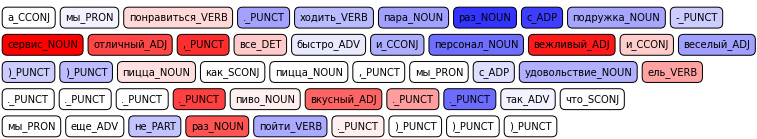

In [80]:
plot_text_heatmap(
    texts_train[100],
    a[0][0]
)

Review(id=0): сегодня_ADV обедать_VERB !_PUNCT мнение_NOUN о_ADP ресторан_NOUN -_PUNCT отвратительный_ADJ !_PUNCT два_NUM момент_NOUN -_PUNCT гарнир_NOUN к_ADP мясо_NOUN ,_PUNCT в_ADP серьезный_ADJ заведение_NOUN он_PRON уже_ADV в_ADP ключен_VERB в_ADP сей_NOUN тоимость_NOUN ,_PUNCT либо_CCONJ стоить_VERB процент_NOUN 20_NUM от_ADP стоимость_NOUN горячий_ADJ ,_PUNCT здесь_ADV стоить_VERB дорогой_ADV телятина_NOUN -_PUNCT 400_NUM рубль_NOUN ._PUNCT по-сокльку_SCONJ я_PRON ,_PUNCT обычно_ADV ,_PUNCT на_ADP стоимость_NOUN гарнир_NOUN не_PART акцентировать_VERB внимание_NOUN -_PUNCT в_ADP этот_DET раз_NOUN быть_AUX очень_ADV удивить_VERB и_CCONJ мочь_VERB отнести_VERB это_PRON к_ADP лохотрона_NOUN ,_PUNCT либо_CCONJ к_ADP борзот_NOUN ._PUNCT второй_ADJ факт_NOUN ,_PUNCT опускать_VERB заведение_NOUN на_ADP дно_NOUN сервис_NOUN -_PUNCT это_PRON принуждение_NOUN Вас_PRON по_ADP умолчание_NOUN оплатить_VERB работа_NOUN офциант_NOUN -_PUNCT бездарь_NOUN ._PUNCT факт_NOUN обязательный_ADJ оплата

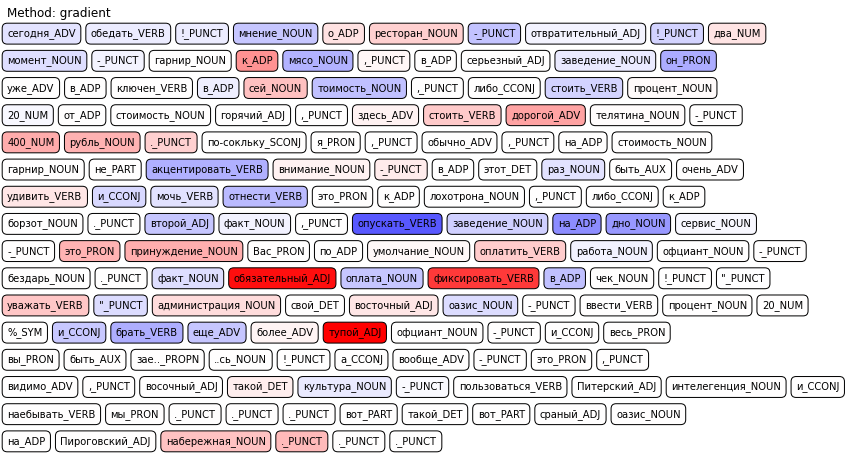

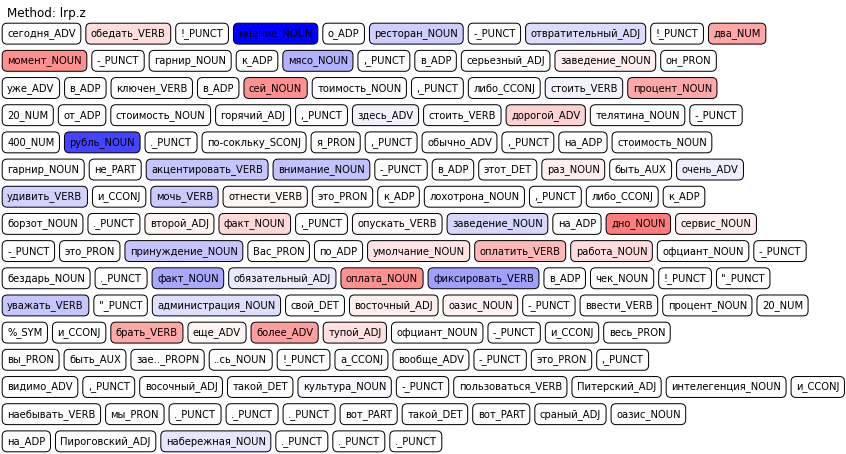

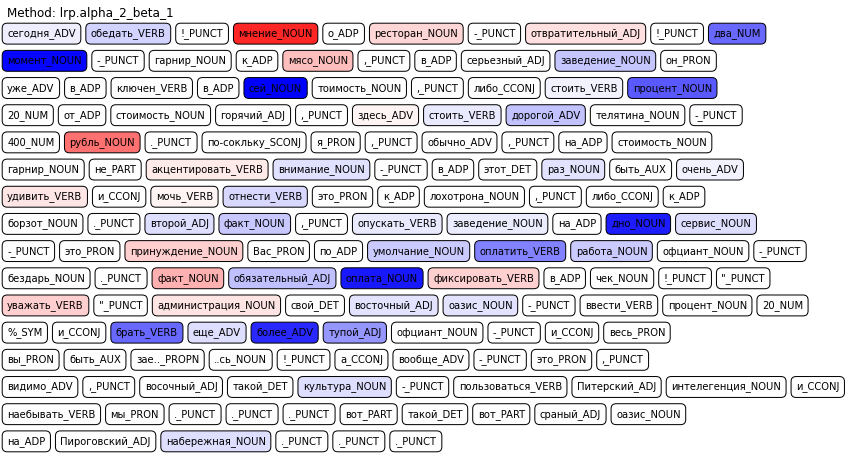

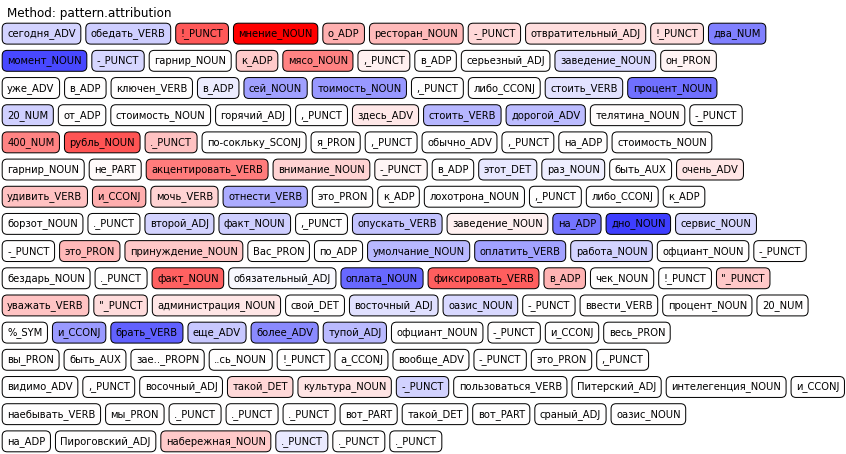

In [81]:
idx = 0
words = texts_val[idx]
    
print('Review(id=%d): %s' % (idx, ' '.join(words)))
y_true = scores_val[idx]
a, y_pred = analyze_scores(input_tensor_val, scores_val, idx)

print("Pred class : %d %s" %
      (y_pred, '✓' if y_pred == y_true else '✗ (%d)' % y_true)
      )
                            
for j, method in enumerate(methods):
    plot_text_heatmap(words, a[j].reshape(-1), title='Method: %s' % method, verbose=0)
    plt.show()
    print()